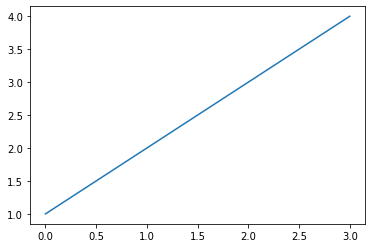

In [1]:
import matplotlib.pyplot as plt

plt.plot([1,2,3,4])

import math
import torch
from torch import nn, Tensor
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchsummary import summary


import pandas as pd
import numpy as np
import time

from models import ensembleModel, resnetModel, transformerModel

import sys
from quantnote import BacktestEngine


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Load datasets

In [3]:
class MyDataset(Dataset):
    def __init__(self, feature_arr, label_arr):
        self.feature_arr = feature_arr
        self.label_arr = label_arr
        assert len(feature_arr) == len(label_arr)
        
    def __len__(self):
        return len(self.label_arr)

    def __getitem__(self, idx):
        feature = self.feature_arr[idx]
        label = self.label_arr[idx]
        return feature, label

train_dataset_2018 = torch.load('train_datatset_2018-01-01.pt')
val_dataset_2018 = torch.load('val_datatset_2018-01-01.pt')
train_dataset_2019 = torch.load('train_datatset_2019-01-01.pt')
val_dataset_2019 = torch.load('val_datatset_2019-01-01.pt')
train_dataset_2020 = torch.load('train_datatset_2020-01-01.pt')
val_dataset_2020 = torch.load('val_datatset_2020-01-01.pt')
train_dataset_2021 = torch.load('train_datatset_2021-01-01.pt')
val_dataset_2021 = torch.load('val_datatset_2021-01-01.pt')

BATCH_SIZE = 64

train_dataloader_18 = DataLoader(train_dataset_2018, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_18 = DataLoader(val_dataset_2018, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_19 = DataLoader(train_dataset_2019, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_19 = DataLoader(val_dataset_2019, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_20 = DataLoader(train_dataset_2020, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_20 = DataLoader(val_dataset_2020, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_21 = DataLoader(train_dataset_2021, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_21 = DataLoader(val_dataset_2021, batch_size=BATCH_SIZE, shuffle=True)

for X, y in train_dataloader_21:
    print("Shape of X: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X:  torch.Size([64, 60, 54])
Shape of y:  torch.Size([64, 1]) torch.float64


#### View featuer data

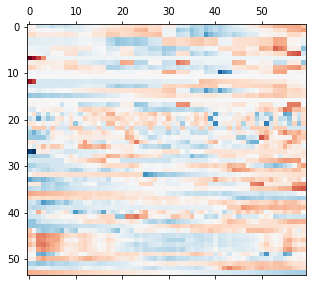

In [4]:
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(np.transpose(X[0]), cmap='RdBu')

### Train & Test loop in pytorch

In [5]:
def train_step(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    correct, total_count = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.type(torch.cuda.FloatTensor)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        total_count += len(y)
        correct += ( (pred > 0)  == y).type(torch.float).sum().item()
        accuracy = correct/total_count
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_list.append(loss)
            avg_loss = np.mean(loss_list)
            print(
                f"[Train metric] Accuracy: {(100*accuracy):>0.2f}%, train_loss: {avg_loss:>8f} ({total_count:>5d}/{size:>5d})", 
                end='\r')
            
    print(
        f"[Train metric] Accuracy: {(100*accuracy):>0.2f}%, train_loss: {avg_loss:>8f} ({total_count:>5d}/{size:>5d})")
    return avg_loss

            
def test_step(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.type(torch.cuda.FloatTensor)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ( (pred > 0)  == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"[Validation metric] Accuracy: {(100*correct):>0.2f}%, val_loss: {test_loss:>8f}")
    return test_loss


def train(model,train_dataloader, val_dataloader, loss_fn, optimizer, patience=3, epochs=100, checkpoint_path='checkpoint.pt'):
    train_loss_list = []
    val_loss_list = []
    stime = time.time()
    for t in range(epochs):
        print(f"-------------------------------\nEpoch {t+1}")
        train_loss = train_step(train_dataloader, model, loss_fn, optimizer)
        val_loss = test_step(val_dataloader, model, loss_fn)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print('epoch time: {}'.format(time.time()-stime))
        stime = time.time()

        if val_loss == np.min(val_loss_list):
            load_count = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, checkpoint_path)

        else:
            load_count += 1
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            print('Model loaded. Current best loss = {}'.format(np.min(val_loss_list)))

        if load_count >= patience:
            break
        
    history = {}
    history['train_loss'] = train_loss_list
    history['val_loss'] = val_loss_list
    print('Done')
    return history

### Train Ensemble model

#### Define model for four data-sets

In [6]:
with torch.no_grad():
    torch.cuda.empty_cache()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

ensemble_model_18 = ensembleModel().to(device)
ensemble_model_19 = ensembleModel().to(device)
ensemble_model_20 = ensembleModel().to(device)
ensemble_model_21 = ensembleModel().to(device)

print(count_parameters(ensemble_model_21))

print(summary(ensemble_model_21, (60, 54) ))


8510979
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3240]               0
            Linear-2                 [-1, 1024]       3,318,784
            Linear-3                  [-1, 512]         524,800
            Linear-4                 [-1, 1024]         525,312
           Dropout-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
            Linear-7                  [-1, 256]         131,328
            Linear-8                  [-1, 512]         131,584
           Dropout-9                  [-1, 512]               0
           Linear-10                    [-1, 1]             513
      resnetModel-11                    [-1, 1]               0
PositionalEncoding-12               [-1, 60, 54]               0
           Linear-13              [-1, 60, 256]          14,080
          Flatten-14          

#### Train model for four data-sets

In [7]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(ensemble_model_18.parameters(), lr=10**(-4.))
history_18 =train(ensemble_model_18, train_dataloader_18, val_dataloader_18, loss_fn, optimizer, 
                  patience=3, epochs=1000, checkpoint_path='checkpoint_18.pt')

-------------------------------
Epoch 1
[Train metric] Accuracy: 50.28%, train_loss: 0.695511 (46339/46339)
[Validation metric] Accuracy: 49.65%, val_loss: 0.694032
epoch time: 16.383653163909912
-------------------------------
Epoch 2
[Train metric] Accuracy: 50.57%, train_loss: 0.694191 (46339/46339)
[Validation metric] Accuracy: 53.24%, val_loss: 0.691077
epoch time: 11.379285335540771
-------------------------------
Epoch 3
[Train metric] Accuracy: 52.07%, train_loss: 0.692379 (46339/46339)
[Validation metric] Accuracy: 51.46%, val_loss: 0.692587
epoch time: 11.313771963119507
Model loaded. Current best loss = 0.6910766922736186
-------------------------------
Epoch 4
[Train metric] Accuracy: 51.84%, train_loss: 0.692532 (46339/46339)
[Validation metric] Accuracy: 53.02%, val_loss: 0.690993
epoch time: 11.415107250213623
-------------------------------
Epoch 5
[Train metric] Accuracy: 54.00%, train_loss: 0.689217 (46339/46339)
[Validation metric] Accuracy: 53.73%, val_loss: 0.68798

In [8]:
0.6790273365544779

0.6790273365544779

In [9]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(ensemble_model_19.parameters(), lr=10**(-4.))
history_19 =train(ensemble_model_19, train_dataloader_19, val_dataloader_19, loss_fn, optimizer, 
                  patience=3, epochs=1000, checkpoint_path='checkpoint_19.pt')

-------------------------------
Epoch 1
[Train metric] Accuracy: 50.29%, train_loss: 0.695262 (52033/52033)
[Validation metric] Accuracy: 50.08%, val_loss: 0.693355
epoch time: 14.145462989807129
-------------------------------
Epoch 2
[Train metric] Accuracy: 50.36%, train_loss: 0.694228 (52033/52033)
[Validation metric] Accuracy: 52.17%, val_loss: 0.692494
epoch time: 12.831835508346558
-------------------------------
Epoch 3
[Train metric] Accuracy: 51.92%, train_loss: 0.692069 (52033/52033)
[Validation metric] Accuracy: 53.36%, val_loss: 0.690018
epoch time: 12.817432641983032
-------------------------------
Epoch 4
[Train metric] Accuracy: 53.28%, train_loss: 0.689981 (52033/52033)
[Validation metric] Accuracy: 53.80%, val_loss: 0.688276
epoch time: 13.028200626373291
-------------------------------
Epoch 5
[Train metric] Accuracy: 55.16%, train_loss: 0.684892 (52033/52033)
[Validation metric] Accuracy: 54.64%, val_loss: 0.686137
epoch time: 13.167154550552368
--------------------

In [10]:
0.6768294121066922

0.6768294121066922

In [11]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(ensemble_model_20.parameters(), lr=10**(-4.))
history_20 =train(ensemble_model_20, train_dataloader_20, val_dataloader_20, loss_fn, optimizer, 
                  patience=3, epochs=1000, checkpoint_path='checkpoint_20.pt')

-------------------------------
Epoch 1
[Train metric] Accuracy: 50.31%, train_loss: 0.694691 (58161/58161)
[Validation metric] Accuracy: 50.97%, val_loss: 0.692666
epoch time: 15.593602895736694
-------------------------------
Epoch 2
[Train metric] Accuracy: 50.31%, train_loss: 0.693949 (58161/58161)
[Validation metric] Accuracy: 52.33%, val_loss: 0.691116
epoch time: 14.58699893951416
-------------------------------
Epoch 3
[Train metric] Accuracy: 51.89%, train_loss: 0.691686 (58161/58161)
[Validation metric] Accuracy: 54.04%, val_loss: 0.688506
epoch time: 14.413132905960083
-------------------------------
Epoch 4
[Train metric] Accuracy: 54.03%, train_loss: 0.687868 (58161/58161)
[Validation metric] Accuracy: 53.77%, val_loss: 0.688181
epoch time: 14.45218014717102
-------------------------------
Epoch 5
[Train metric] Accuracy: 55.68%, train_loss: 0.682592 (58161/58161)
[Validation metric] Accuracy: 55.45%, val_loss: 0.683105
epoch time: 14.345380306243896
----------------------

In [12]:
0.6762133206760511

0.6762133206760511

In [13]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(ensemble_model_21.parameters(), lr=10**(-4.))
history_21 =train(ensemble_model_21, train_dataloader_21, val_dataloader_21, loss_fn, optimizer, 
                  patience=3, epochs=1000, checkpoint_path='checkpoint_21.pt')

-------------------------------
Epoch 1
[Train metric] Accuracy: 50.87%, train_loss: 0.694158 (64193/64193)
[Validation metric] Accuracy: 50.73%, val_loss: 0.693366
epoch time: 16.053611516952515
-------------------------------
Epoch 2
[Train metric] Accuracy: 52.61%, train_loss: 0.691289 (64193/64193)
[Validation metric] Accuracy: 53.25%, val_loss: 0.689553
epoch time: 15.891910314559937
-------------------------------
Epoch 3
[Train metric] Accuracy: 54.42%, train_loss: 0.686664 (64193/64193)
[Validation metric] Accuracy: 53.88%, val_loss: 0.687062
epoch time: 15.95283579826355
-------------------------------
Epoch 4
[Train metric] Accuracy: 56.18%, train_loss: 0.681423 (64193/64193)
[Validation metric] Accuracy: 55.16%, val_loss: 0.683898
epoch time: 15.945562601089478
-------------------------------
Epoch 5
[Train metric] Accuracy: 57.92%, train_loss: 0.673802 (64193/64193)
[Validation metric] Accuracy: 55.67%, val_loss: 0.682513
epoch time: 16.02304220199585
----------------------

In [14]:
0.6775109532390579

0.6775109532390579